In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns

from scipy.stats import shapiro, levene, normaltest, anderson, kstest, skew, kurtosis, spearmanr

#statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statannot import add_stat_annotation
#piongouin
import pingouin as pg

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


In [2]:
data = pd.read_csv("../data/train.csv")

In [3]:
# Checking N~ of data Shapiro-Wilks -> H0 Data is N~

def sw_test(data, columns, alpha=0.05):
    
    """ 
Description
--------------------------------------------
    
    Function that implements Shapiro-Wilks test.
    H0 = Data is N~ distributed. 
    
    *Requires 'from scipy.stats import shapiro'
    
    Excludes nan
    
    
Params
------------------------------------------
    
    x : pandas.DataFrame
    
    columns : list like of column's names
    
    alpha : Significance level. Default 0.05
    
Returns
-------------------------------------------------
    Var name, statistic, pvalue, Reject or Fail to Reject H0
    """
    for i in range(len(columns)):
        
        column = columns[i]
        var= data.loc[data[column].notna()][column]
        n = len(var)
        
        stat, pvalue = shapiro(var)
        print(f"Variable: {columns[i]}, n={n}")
        print(f'Statistic: {stat}, pvalue: {pvalue}')
        print("H0: Data is N~ distributed\n")
        if pvalue < alpha:
            print("Reject H0: Variable is not Normaly distributed")
            print("----------------------------------------------------------------\n")
        else:
            print("Fail to Reject H0: Variable is Normaly distributed")

In [6]:
num_features = ['year_birth', 'years_education', 'moca_total', 'aceiii_total', 'mmse_total',
                'ifs_total_score', 'mini_sea_total', 'barthel_total', 'pfeffer_total',
                'npi_total', 'npi_total_caregiver', 'mmse_vs','mmse_lw', 'moca_vs', 'moca_lw',
                'ace_vs', 'ace_lw', 'cognition','functionality']

### Normality test (Shapiro-Wilks)

In [12]:
sw_test(data, num_features)

Variable: year_birth, n=1424
Statistic: 0.9893189668655396, pvalue: 1.073329158884917e-08
H0: Data is N~ distributed

Reject H0: Variable is not Normaly distributed
----------------------------------------------------------------

Variable: years_education, n=1445
Statistic: 0.9754745364189148, pvalue: 5.581356740441603e-15
H0: Data is N~ distributed

Reject H0: Variable is not Normaly distributed
----------------------------------------------------------------

Variable: moca_total, n=558
Statistic: 0.9386824369430542, pvalue: 2.1702088639618394e-14
H0: Data is N~ distributed

Reject H0: Variable is not Normaly distributed
----------------------------------------------------------------

Variable: aceiii_total, n=439
Statistic: 0.9371364116668701, pvalue: 1.170817132481461e-12
H0: Data is N~ distributed

Reject H0: Variable is not Normaly distributed
----------------------------------------------------------------

Variable: mmse_total, n=1159
Statistic: 0.8939646482467651, pvalue: 1.

### ANOVA

In [17]:
anova = pg.anova(dv='years_education', between=['sex'], effsize='n2', data=data,
             detailed=True).round(3)
#'n2' for unbalanced
anova

,Source,SS,DF,MS,F,p-unc,n2
0,sex,443.523,1,443.523,18.52,0.0,0.013
1,Within,34558.267,1443,23.949,NaN,NaN,NaN


In [20]:
print(f"Tukey post-hoc test")
data.pairwise_tukey(dv='years_education', between='sex')

Tukey post-hoc test


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0.0,1.0,12.676136,11.525627,1.150509,0.267347,4.303433,0.001,0.234975


In [ ]:
# U-test (p-value y tamaño de efecto)
# ==============================================================================
pg.mwu(x=valores_A, y=valores_B, alternative='two-sided')


In [21]:
anova = pg.anova(dv='years_education', between=['diagnosis'], effsize='n2', data=data,
             detailed=True).round(3)
#'n2' for unbalanced
anova

,Source,SS,DF,MS,F,p-unc,n2
0,diagnosis,3507.848,2,1753.924,80.306,0.0,0.1
1,Within,31493.941,1442,21.840,NaN,NaN,NaN


In [22]:
print(f"Tukey post-hoc test")
data.pairwise_tukey(dv='years_education', between='diagnosis')

Tukey post-hoc test


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,AD,CN,10.453567,13.78903,-3.335463,0.274721,-12.141254,0.001000,-0.713275
1,AD,FTD,10.453567,12.97807,-2.524504,0.353817,-7.135055,0.001000,-0.539770
2,CN,FTD,13.789030,12.97807,0.810959,0.376654,2.153061,0.079915,0.173341


In [25]:
for i in range(len(num_features)):
    feature = num_features[i]
    print(f"ANOVA for {feature} and Dx\n")
    anova = pg.anova(dv=feature, between=['diagnosis'], effsize='n2', data=data,
             detailed=True).round(3)
    #'n2' for unbalanced
    print(anova)
    print(f"\nTukey post-hoc test")
    print(data.pairwise_tukey(dv=feature, between='diagnosis'))
    print("###############################################################\n")

ANOVA for year_birth and Dx

      Source          SS    DF         MS        F  p-unc     n2
0  diagnosis   22635.049     2  11317.524  116.273    0.0  0.141
1     Within  138314.139  1421     97.336      NaN    NaN    NaN

Tukey post-hoc test
    A    B      mean(A)      mean(B)      diff        se          T  p-tukey  \
0  AD   CN  1939.720867  1947.046908 -7.326041  0.582606 -12.574597   0.0010   
1  AD  FTD  1939.720867  1948.843318 -9.122451  0.761868 -11.973790   0.0010   
2  CN  FTD  1947.046908  1948.843318 -1.796410  0.809994  -2.217805   0.0686   

     hedges  
0 -0.742100  
1 -0.923918  
2 -0.181883  
###############################################################

ANOVA for years_education and Dx

      Source         SS    DF        MS       F  p-unc   n2
0  diagnosis   3507.848     2  1753.924  80.306    0.0  0.1
1     Within  31493.941  1442    21.840     NaN    NaN  NaN

Tukey post-hoc test
    A    B    mean(A)   mean(B)      diff        se          T   p-tukey  \
0 

      Source      SS    DF      MS       F  p-unc     n2
0  diagnosis  31.219     2  15.610  550.39    0.0  0.432
1     Within  41.038  1447   0.028     NaN    NaN    NaN

Tukey post-hoc test
    A    B   mean(A)   mean(B)      diff        se          T  p-tukey  \
0  AD   CN  0.591751  0.914390 -0.322639  0.009884 -32.641243    0.001   
1  AD  FTD  0.591751  0.645676 -0.053925  0.012705  -4.244286    0.001   
2  CN  FTD  0.914390  0.645676  0.268713  0.013524  19.869841    0.001   

     hedges  
0 -1.914649  
1 -0.319962  
2  1.593919  
###############################################################

ANOVA for functionality and Dx

      Source      SS   DF     MS       F  p-unc     n2
0  diagnosis   8.554    2  4.277  84.337    0.0  0.186
1     Within  37.378  737  0.051     NaN    NaN    NaN

Tukey post-hoc test
    A    B   mean(A)   mean(B)      diff        se          T  p-tukey  \
0  AD   CN  0.424378  0.184049  0.240329  0.019200  12.517125    0.001   
1  AD  FTD  0.424378  0.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CN_Male v.s. CN_Female: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-9.190e-01
AD_Male v.s. AD_Female: Welch's t-test independent samples with Bonferroni correction, P_val=2.458e-02 stat=2.653e+00
FTD_Male v.s. FTD_Female: Welch's t-test independent samples with Bonferroni correction, P_val=2.673e-02 stat=2.638e+00


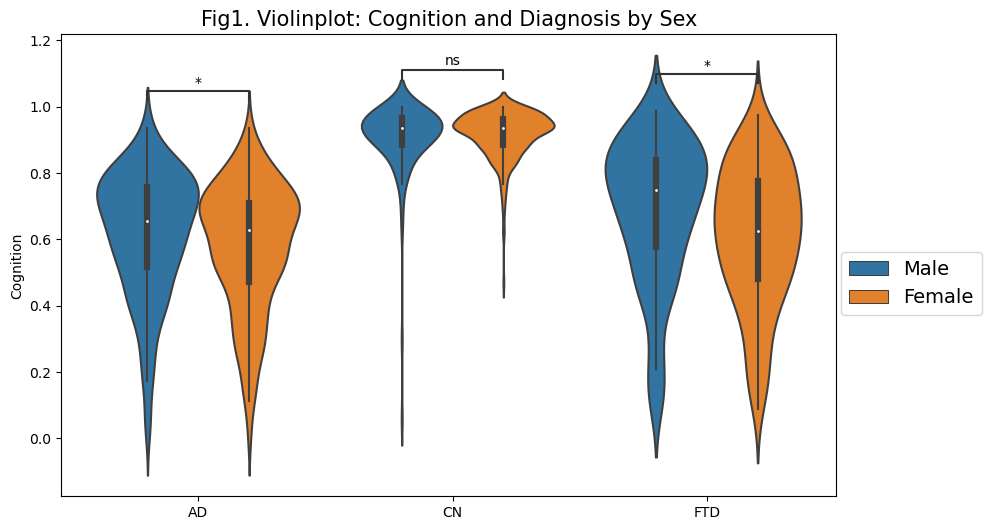

In [29]:
fig , ax = plt.subplots(figsize=(10,6))

datos = data.copy()
datos.sex.replace({0:"Male", 1:"Female"}, inplace=True)

ax = sns.violinplot(x='diagnosis', y="cognition", hue="sex", data=datos,
                 showmeans=True, meanprops={"markersize":"5"})
ax.set_title("Fig1. Violinplot: Cognition and Diagnosis by Sex", fontsize=15)

handles, _ = ax.get_legend_handles_labels()          # Get the artists.
ax.legend(handles, ["Male", "Female"], bbox_to_anchor=(1.2, 0.55), fontsize=14) # Associate manually the artists to a label.
ax.set_xlabel("")
ax.set_ylabel("Cognition")

# text = "* ANOVA: Age ~ Diagnosis +  Gender."
# ax.annotate(
# # Label and coordinate
# text, xy=(1, 100),xytext=(2.05, 25) ,fontsize=9,
# horizontalalignment="center",
# # Custom arrow
# # arrowprops=dict(arrowstyle='->',lw=2)
# )

add_stat_annotation(ax, data=datos, x='diagnosis', y='cognition', hue='sex',
                    box_pairs=[( ("CN", "Male"), ("CN", "Female") ),
                             ( ("AD", "Male"), ("AD", "Female") ),
                             ( ("FTD", "Male"), ("FTD", "Female") )],
                    test='t-test_welch', text_format='star', loc='inside', verbose=1)

# plt.savefig('./graphs/fig6.png')
plt.show()

In [31]:
data.moca_total

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1445   NaN
1446   NaN
1447   NaN
1448   NaN
1449   NaN
Name: moca_total, Length: 1450, dtype: float64

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CN v.s. AD: Welch's t-test independent samples with Bonferroni correction, P_val=3.667e-148 stat=3.161e+01
AD v.s. FTD: Welch's t-test independent samples with Bonferroni correction, P_val=9.290e-03 stat=-2.986e+00
CN v.s. FTD: Welch's t-test independent samples with Bonferroni correction, P_val=3.571e-28 stat=1.308e+01


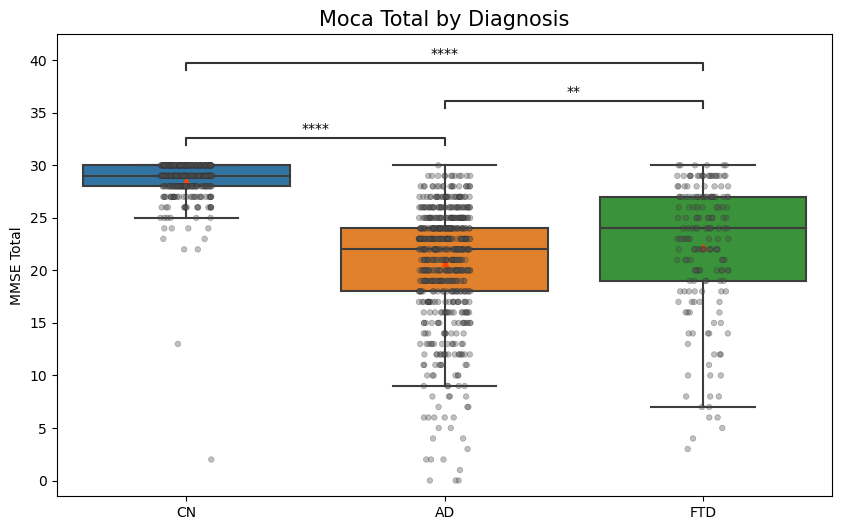

In [75]:
fig , ax = plt.subplots(figsize=(10,6))

df = data.copy()
df.sex.replace({0: "Male", 1: "Female"})

ax = sns.boxplot(x='diagnosis', y="mmse_total", data=df, order=['CN', 'AD', 'FTD'],
                 showmeans=True, meanprops={"markersize":"5", "markerfacecolor":"#ff4500",
                                           'markeredgecolor':'#ff4500'}, showfliers=False)
ax.set_title("Moca Total by Diagnosis", fontsize=15)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['CN', 'AD', 'FTD'])

# Add in points to show each observation
ax1 = sns.stripplot(x="diagnosis", y="mmse_total", data=df, order=['CN', 'AD', 'FTD'],
              size=4, color=".3", linewidth=.5, alpha=0.35)

# # Tweak the visual presentation
# ax1.xaxis.grid(True)
# ax1.set(ylabel="")
# sns.despine(trim=True, left=True)

add_stat_annotation(ax, data=datos, x='diagnosis', y='mmse_total', order=["CN", "AD", "FTD"],
                    box_pairs=[("CN", "AD"), ("CN", "FTD"), ("AD", "FTD")],
                    test='t-test_welch', text_format='star', loc='inside', verbose=1)

# # #handles, _ = ax.get_legend_handles_labels()          # Get the artists.
# # #ax.legend(title ='CDR Score', bbox_to_anchor=(1.2, 0.65), fontsize=14) # Associate manually the artists to a label.
ax.set_xlabel("")
ax.set_ylabel("MMSE Total");
plt.show()

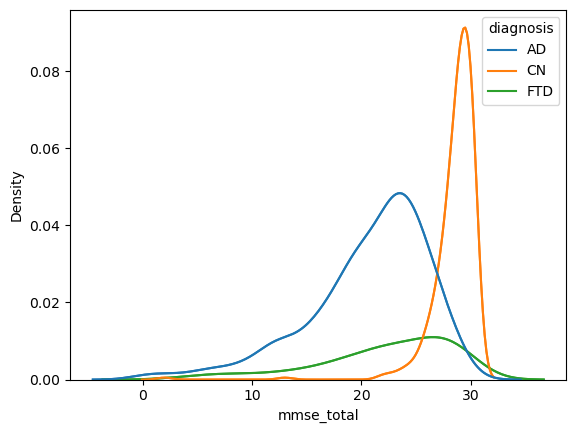

In [78]:
sns.kdeplot(x='mmse_total', hue='diagnosis', data=data)
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CN v.s. AD: Welch's t-test independent samples with Bonferroni correction, P_val=9.969e-222 stat=3.997e+01
AD v.s. FTD: Welch's t-test independent samples with Bonferroni correction, P_val=4.122e-02 stat=-2.477e+00
CN v.s. FTD: Welch's t-test independent samples with Bonferroni correction, P_val=3.483e-51 stat=1.889e+01


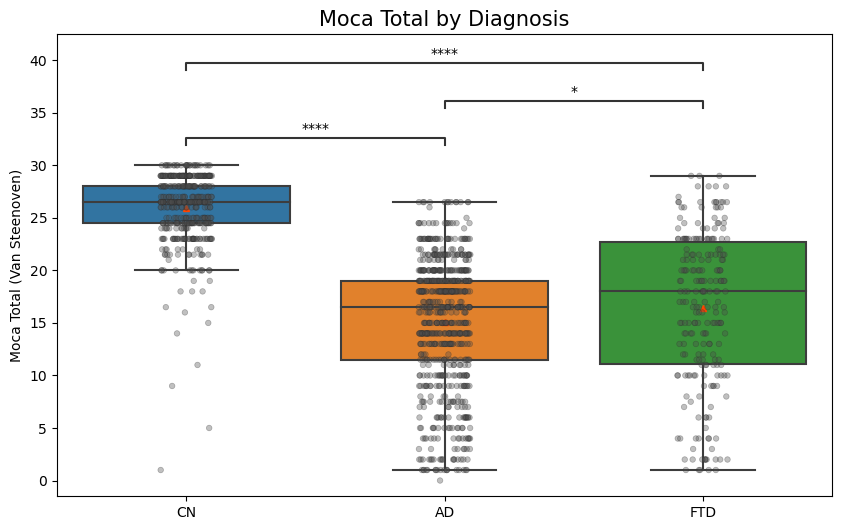

In [62]:
fig , ax = plt.subplots(figsize=(10,6))

df = data.copy()
df.sex.replace({0: "Male", 1: "Female"})

ax = sns.boxplot(x='diagnosis', y="moca_vs", data=df, order=['CN', 'AD', 'FTD'],
                 showmeans=True, meanprops={"markersize":"5", "markerfacecolor":"#ff4500",
                                           'markeredgecolor':'#ff4500'}, showfliers=False)
ax.set_title("Moca Total by Diagnosis", fontsize=15)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['CN', 'AD', 'FTD'])

# Add in points to show each observation
ax1 = sns.stripplot(x="diagnosis", y="moca_vs", data=df, order=['CN', 'AD', 'FTD'],
              size=4, color=".3", linewidth=.5, alpha=0.35)

# # Tweak the visual presentation
# ax1.xaxis.grid(True)
# ax1.set(ylabel="")
# sns.despine(trim=True, left=True)

add_stat_annotation(ax, data=datos, x='diagnosis', y='moca_vs', order=["CN", "AD", "FTD"],
                    box_pairs=[("CN", "AD"), ("CN", "FTD"), ("AD", "FTD")],
                    test='t-test_welch', text_format='star', loc='inside', verbose=1)

# # #handles, _ = ax.get_legend_handles_labels()          # Get the artists.
# # #ax.legend(title ='CDR Score', bbox_to_anchor=(1.2, 0.65), fontsize=14) # Associate manually the artists to a label.
ax.set_xlabel("")
ax.set_ylabel("Moca Total (Van Steenoven)");
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CN v.s. AD: Welch's t-test independent samples with Bonferroni correction, P_val=1.221e-219 stat=4.043e+01
AD v.s. FTD: Welch's t-test independent samples with Bonferroni correction, P_val=2.286e-03 stat=-3.397e+00
CN v.s. FTD: Welch's t-test independent samples with Bonferroni correction, P_val=5.865e-48 stat=1.819e+01


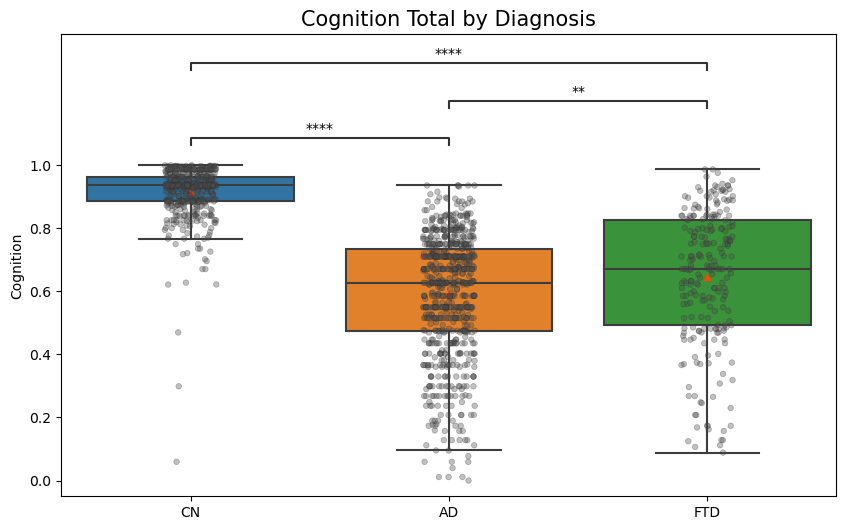

In [74]:

fig , ax = plt.subplots(figsize=(10,6))

df = data.copy()
df.sex.replace({0: "Male", 1: "Female"})

ax = sns.boxplot(x='diagnosis', y="cognition", data=df, order=['CN', 'AD', 'FTD'],
                 showmeans=True, meanprops={"markersize":"5", "markerfacecolor":"#ff4500",
                                           'markeredgecolor':'#ff4500'}, showfliers=False)
ax.set_title("Cognition Total by Diagnosis", fontsize=15)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['CN', 'AD', 'FTD'])
# ax.set_yticklabels([0.0,0.0,0.2, 0.4, 0.6, 0.8, 1.0])
# Set the y-axis ticks using FixedLocator
ax.yaxis.set_major_locator(FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))

# Set the y-axis tick labels using FixedFormatter
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])


# Add in points to show each observation
ax1 = sns.stripplot(x="diagnosis", y="cognition", data=df, order=['CN', 'AD', 'FTD'],
              size=4, color=".3", linewidth=.5, alpha=0.35)

# # Tweak the visual presentation
# ax1.xaxis.grid(True)
# ax1.set(ylabel="")
# sns.despine(trim=True, left=True)

add_stat_annotation(ax, data=datos, x='diagnosis', y='cognition', order=["CN", "AD", "FTD"],
                    box_pairs=[("CN", "AD"), ("CN", "FTD"), ("AD", "FTD")],
                    test='t-test_welch', text_format='star', loc='inside', verbose=1)

# # #handles, _ = ax.get_legend_handles_labels()          # Get the artists.
# # #ax.legend(title ='CDR Score', bbox_to_anchor=(1.2, 0.65), fontsize=14) # Associate manually the artists to a label.
ax.set_xlabel("")
ax.set_ylabel("Cognition");
plt.show()

In [65]:
data.cognition.max()

1.0

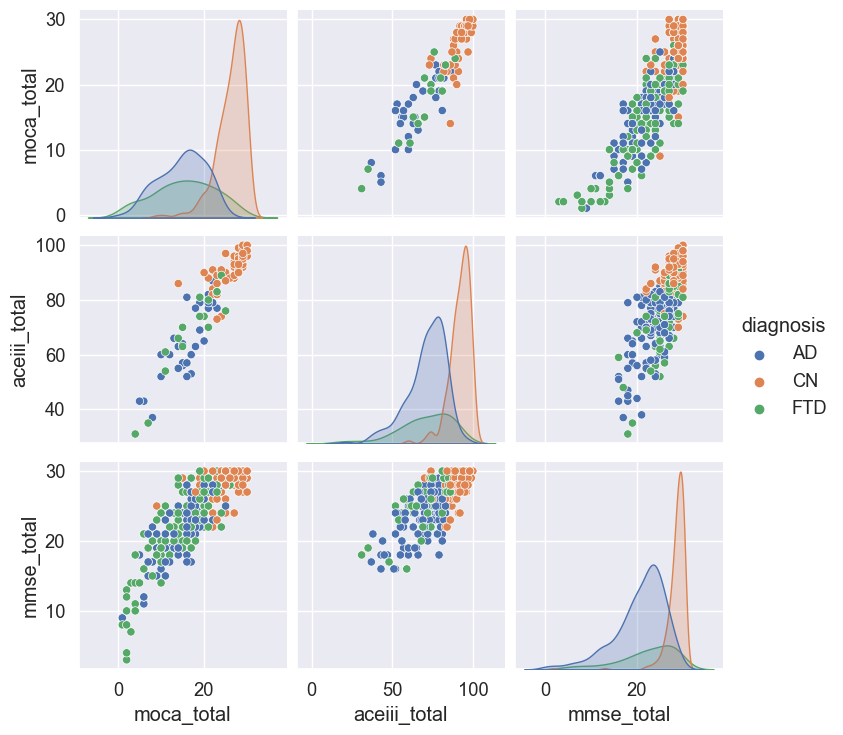

In [85]:
sns.set_theme(context='notebook', style="darkgrid", font_scale=1.2)

df = data[["diagnosis", 'moca_total', 'aceiii_total','mmse_total']]
sns.pairplot(df, hue="diagnosis", vars=['moca_total', 'aceiii_total','mmse_total'])
plt.show()

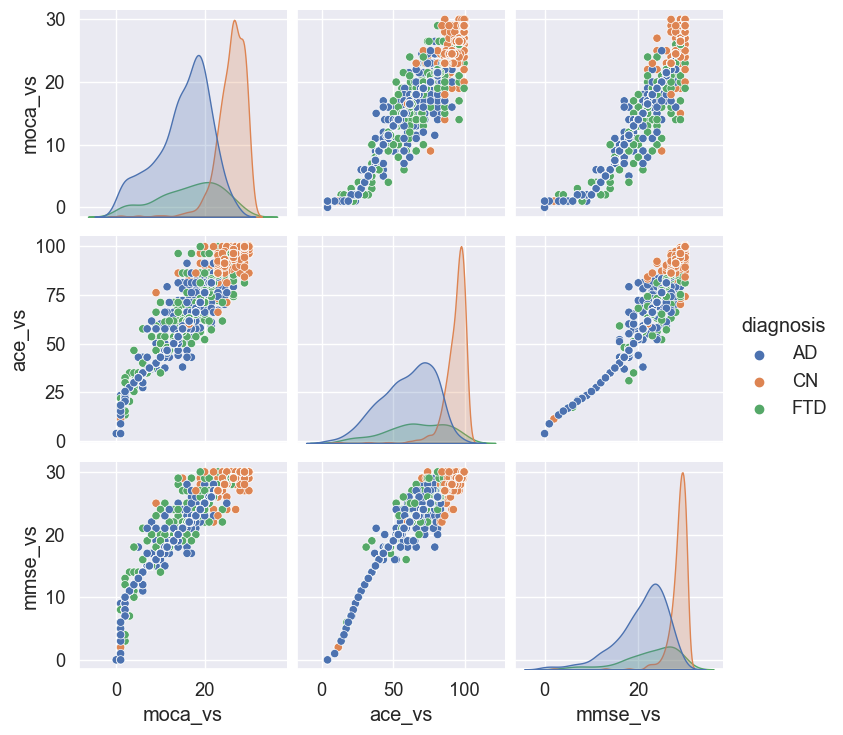

In [84]:
sns.set_theme(context='notebook', style="darkgrid", font_scale=1.2)

df = data[["diagnosis", 'moca_vs', 'ace_vs','mmse_vs']]
sns.pairplot(df, hue="diagnosis", vars=['moca_vs', 'ace_vs','mmse_vs'])
plt.show()

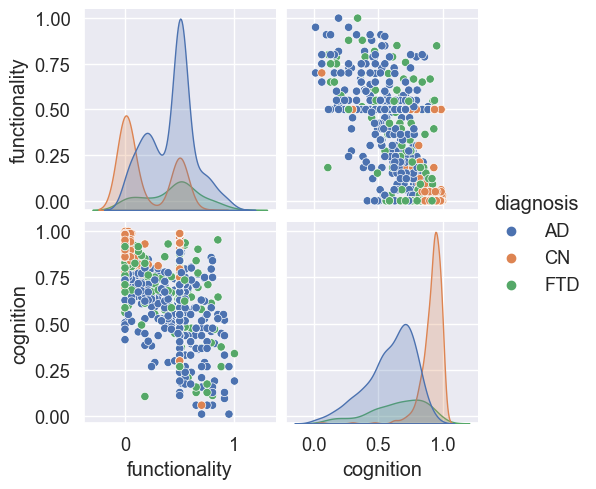

In [86]:
sns.set_theme(context='notebook', style="darkgrid", font_scale=1.2)

df = data[["diagnosis", 'functionality', 'cognition']]
sns.pairplot(df, hue="diagnosis", vars=['functionality', 'cognition'])
plt.show()

####  [Bootstraping](https://cienciadedatos.net/documentos/pystats04-bootstrapping-python)

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from scipy.stats import trim_mean

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración matplotlib
# ==============================================================================
style.use('ggplot') or plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Varios
# ==============================================================================
from tqdm import tqdm

In [87]:
# Datos
# ==============================================================================
AD = data.loc[data['diagnosis']=='AD']
FTD = data.loc[data['diagnosis']=='FTD']
CN = data.loc[data['diagnosis']=='CN']

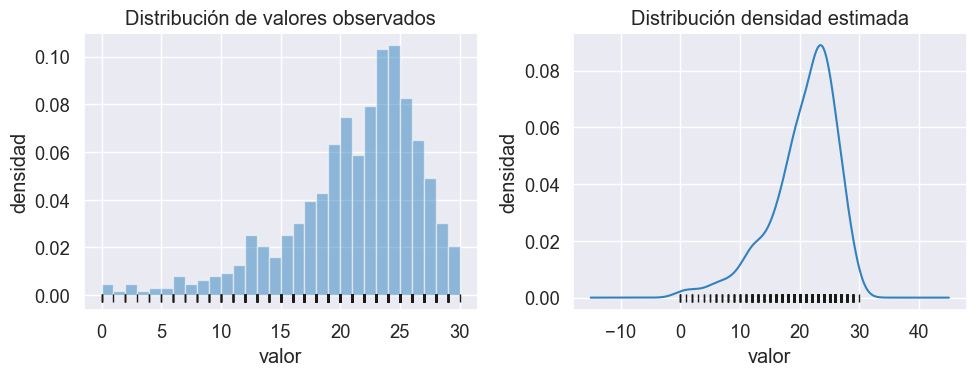

In [117]:
# Gráficos distribución observada
# ==============================================================================

datos = AD['mmse_total'].dropna()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(datos, bins=30, density=True, color='#3182bd', alpha=0.5, label = 'muestra_1')
axs[0].plot(datos, np.full_like(datos, -0.001), '|k', markeredgewidth=1)
axs[0].set_title('Distribución de valores observados')
axs[0].set_xlabel('valor')
axs[0].set_ylabel('densidad')

pd.Series(datos).plot.kde(ax=axs[1],color='#3182bd')
axs[1].plot(datos, np.full_like(datos, 0), '|k', markeredgewidth=1)
axs[1].set_title('Distribución densidad estimada')
axs[1].set_xlabel('valor')
axs[1].set_ylabel('densidad')

fig.tight_layout()
plt.show()

La representación gráfica muestra evidencias de que los datos no se distribuyen de forma normal. Esto implica que, la aproximación basada en el teorema del límite central para estimar el error estándar  SE=sd/sqrt(n)
 , deja de ser buena y con ella los intervalos paramétricos basados en la estructura parámetro estimado ± *t*αSE
 . Una alternativa para poder calcular intervalos de confianza es emplear bootstrapping.
 
 ### Intervalo de confianza basado en percentiles


Mediante bootstrapping, se simula la variabilidad esperada en el estadístico, en este caso la media, debido únicamente al muestreo aleatorio.



In [118]:
def calcular_estadistico(x):
    '''
    Función para calcular el estadístico de interés.
    
    Parameters
    ----------
    x : numpy array
         valores de la muestra.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    estadistico = np.mean(x)
    
    return(estadistico)


def bootstraping(x, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular el valor del estadístico en múltiples muestras generadas
    mediante muestreo repetido con reposición (bootstrapping).
    
    Parameters
    ----------
    x : numpy array
         valores de la muestra.
 
    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número iteraciones (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada muestra de bootstrapping.
    '''
    
    n = len(x)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample)
        
    return dist_boot

In [126]:
datos = AD['mmse_total'].dropna()

dist_boot = bootstraping(
                x = datos,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999 )

100%|██████████| 9999/9999 [00:00<00:00, 24193.80it/s]


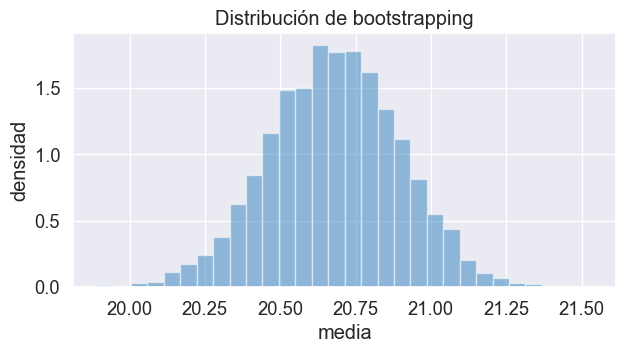

In [129]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,3.3))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
plt.show()

In [130]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[20.24119048 21.09365079]


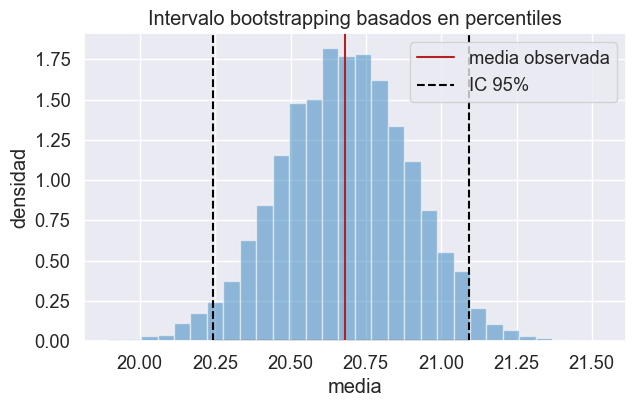

In [133]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=datos.mean(), color='firebrick', label='media observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend()
plt.show()

100%|██████████| 9999/9999 [00:00<00:00, 26845.09it/s]


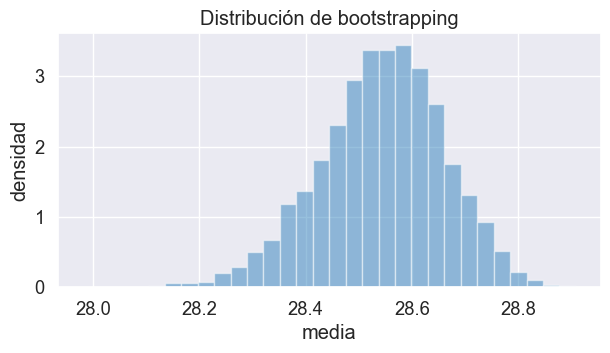

In [134]:
datos = CN['mmse_total'].dropna()
dist_boot = bootstraping(
                x = datos,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999 )

# Gráfico intervalo de confianza del 95%
# ==============================================================================
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,3.3))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
plt.show()

In [135]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[28.2962963  28.75498575]


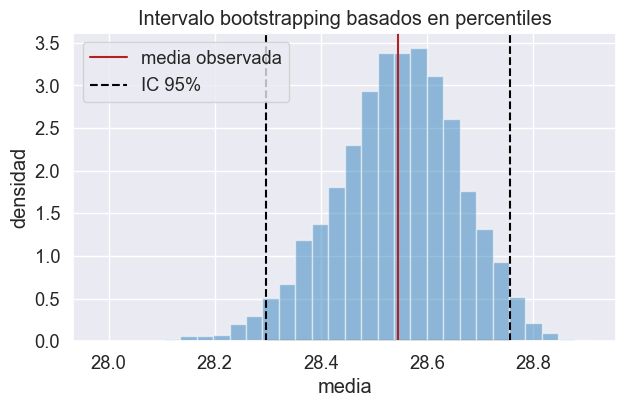

In [136]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=datos.mean(), color='firebrick', label='media observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend()
plt.show()

100%|██████████| 9999/9999 [00:00<00:00, 27781.98it/s]


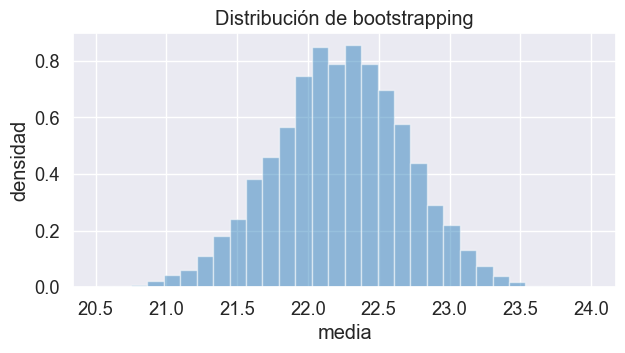

In [137]:
datos = FTD['mmse_total'].dropna()
dist_boot = bootstraping(
                x = datos,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999 )

# Gráfico intervalo de confianza del 95%
# ==============================================================================
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,3.3))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
plt.show()

In [138]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[21.29775281 23.11797753]


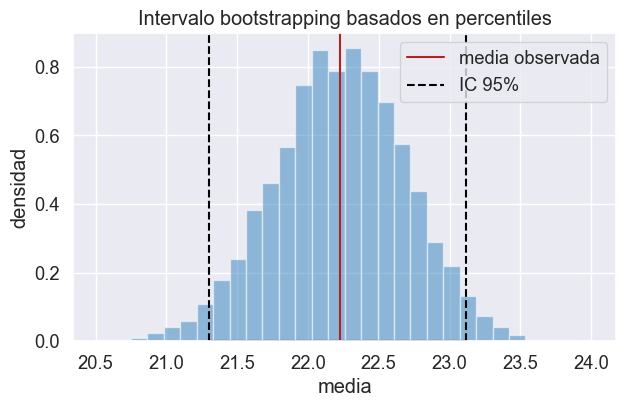

In [139]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=datos.mean(), color='firebrick', label='media observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend()
plt.show()

#### Intervalos empíricos

In [141]:
def calcular_estadistico(x):
    '''
    Función para calcular el estadístico de interés.
    
    Parameters
    ----------
    x : numpy array
         valores de la muestra.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    estadistico = np.mean(x)
    
    return(estadistico)


def bootstraping_empirico(x, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular la diferencia entre el valor del estadístico en la
    muestra original y el valor del estadístico en múltiples muestras generadas
    por muestreo con reposición.
    
    Parameters
    ----------
    x : numpy array
         valores de la muestra.
 
    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número iteraciones (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        valor de la diferencia del estadístico en cada muestra de bootstrapping.
    '''
    
    n = len(x)
    estadistico_muestra = fun_estadistico(x)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample) - estadistico_muestra
        
    return dist_boot

In [142]:
datos = AD['mmse_total'].dropna()
dist_boot = bootstraping_empirico(
                x = datos,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:00<00:00, 23603.24it/s]


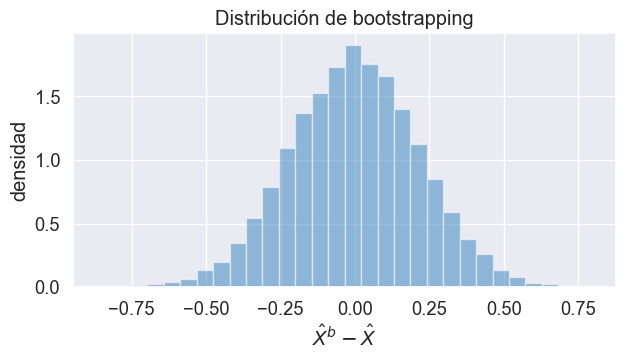

In [145]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,3.3))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.set_title('Distribución de bootstrapping')
ax.set_xlabel(r'$\hat{X}^{b} - \hat{X}$')
ax.set_ylabel('densidad')
plt.show()

La distribución obtenida por bootstrapping es una aproximación de la diferencia que cabe esperar entre el valor del estadístico calculado con los datos de la muestra disponible y el verdadero valor del parámetro poblacional. En este ejemplo en concreto, representa la diferencia que se puede esperar entre la media de la muestra y el valor medio de la población.

In [147]:
# Intervalo IC basado en bootstrapping empírico.
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
estadistico_muestra = calcular_estadistico(datos)
print('------------------')
print('Intervalo empírico')
print('------------------')
intervalo = [estadistico_muestra - cuantiles[1] , estadistico_muestra - cuantiles[0]]
print(intervalo)

------------------
Intervalo empírico
------------------
[20.26190476190476, 21.108015873015873]


**Intervalos teóricos**


Se comparan los intervalos obtenidos, con los intervalos estimados si se emplea un modelo paramétrico basado en una distribución t-student.

In [149]:
from statsmodels.stats.weightstats import DescrStatsW
d1 = DescrStatsW(datos)
print(d1.tconfint_mean(alpha=0.05, alternative='two-sided'))

(20.251330077047946, 21.110574684856815)
